<a href="https://colab.research.google.com/github/Shopping-Yuan/ML2021HW/blob/Shopping_branch/HW2/ML2021HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!gdown --id '1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR' --output data.zip
#!unzip data.zip
#!ls
%conda install -c nvidia cuda-toolkit

Solving environment: ...working... unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: ...working... unsuccessful attempt using repodata from current_repodata.json, retrying with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: d:\Anaconda\envs\ML2021_python_3_11_5

  added / updated specs:
    - cuda-toolkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cuda-command-line-tools-12.1.1|                0           2 KB  nvidia
    cuda-compiler-12.3.0       |                0           2 KB  nvidia
    cuda-cuobjdump-12.3.52     |                0         3.8 MB  nvidia
    cuda-cuxxfilt-12.3.52      |                0         164 KB  nvidia
    cuda-documentation-12.3.52 |                0          89 KB  nvidia
    cuda-nsight-compute-12.3.0 |                0           2 KB  nvi



==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.9.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.9.0
















cuda-nvvp-12.3.52    | 113.6 MB  | ######6    |  67% 















nsight-compute-2023. | 634.5 MB  | 8          |   9% 












cuda-nvvp-12.3.52    | 113.6 MB  | ######6    |  67% 















nsight-compute-2023. | 634.5 MB  | 8          |   9% 












cuda-nvvp-12.3.52    | 113.6 MB  | ######7    |  67% 















nsight-compute-2023. | 634.5 MB  | 9          |   9% 












cuda-nvvp-12.3.52    | 113.6 MB  | ######7    |  67% 















nsight-compute-2023. | 634.5 MB  | 9          |   9% 












cuda-nvvp-12.3.52    | 113.6 MB  | ######7    |  68% 















nsight-compute-2023. | 634.5 MB  | 9          |   9% 












cuda-nvvp-12.3.52    | 113.6 MB  | ######7    |  68% 















nsight-compute-2023. | 634.5 MB  | 9          |   9% 















nsight-compute-2023. | 634.5 MB  | 9          |   9% 












cuda-nvvp-12.3.52    | 113.6 MB  | ######8    |  68% 















nsight-compute-2023. | 634.5 MB  | 9    

In [2]:
#import pytorch
import torch

# torch.backends.cudnn: set CNN algorithmtorch.backends.cudnn
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# get the current available device ('cpu' or 'cuda')
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(torch.cuda.is_available())
#set random variable
import numpy as np
myseed = 1
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

True


In [3]:
#write data_set_function
#normalize data if needed
import pandas as pd
#Dataset:data_set_function
import numpy as np

def TIMIT_train_val_f(mode,d_l = "both"):

  data = np.load(data_info[mode]["data_path"])
  label = np.load(data_info[mode]["label_path"])
  print('Size of training data: {}'.format(data.shape))
  print('Size of training label: {}'.format(label.shape))
  VAL_RATIO = 0.2
  percent = int(data.shape[0] * (1 - VAL_RATIO))
  train_data, train_label, val_data, val_label = \
  data[:percent], label[:percent].astype(np.int_), data[percent:], label[percent:].astype(np.int_)

  if mode == "train":
    return{"data" : torch.FloatTensor(train_data) , "label" : torch.LongTensor(train_label)}
  elif mode == "val":
    return{"data" : torch.FloatTensor(val_data) , "label" : torch.LongTensor(val_label)}

def TIMIT_test_f(mode,d_l = "data"):
  test = np.load(data_info[mode]["path"])
  print('Size of testing data: {}'.format(test.shape))
  return torch.FloatTensor(test)

#create a dict of functions and path w.r.t. different mode
data_info = {
    "train":{"function":TIMIT_train_val_f,"data_path":"./timit_11/train_11.npy","label_path":"./timit_11/train_label_11.npy","data_or_label":"both"},
    "val":{"function":TIMIT_train_val_f,"data_path":"./timit_11/train_11.npy","label_path":"./timit_11/train_label_11.npy","data_or_label":"both"},
    "test":{"function":TIMIT_test_f,"path":"./timit_11/test_11.npy","data_or_label":"data"}
}

In [4]:
#rewrite class Dataset
from torch.utils.data import Dataset, DataLoader
class Dataset_preparation(Dataset):
  def __init__(self,mode,data_info):
      self.mode = mode
      self.data_or_label = data_info[mode]["data_or_label"]

      if self.data_or_label == "data":
        self.data = data_info[self.mode]["function"](self.mode,"data")
      elif self.data_or_label == "both":
        data_and_label = data_info[self.mode]["function"](self.mode,"both")
        self.data = data_and_label["data"]
        self.label = data_and_label["label"]
      else :
        self.label = data_info[self.mode]["function"](self.mode,"label")["label"]

      self.dim = self.data.shape[1]
      print('Finished reading the {mode} set of Dataset ({len} samples found, each dim = {dim})'
              .format(mode = self.mode, len =len(self.data), dim=self.dim))

  def __getitem__(self, index):
      if self.data_or_label == "data":
        return self.data[index]
      elif self.data_or_label == "both":
        return self.data[index], self.label[index]
      else :
        return self.label[index]
  def __len__(self):
      # Returns the size of the dataset
      return len(self.data)

In [5]:
from torch.utils.data import DataLoader
#decide how to load data
def prep_dataloader(mode,d_info,batch_size,n_jobs=0):
    dataset = Dataset_preparation(mode,d_info)
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=False)
    return dataloader

In [6]:
#Model : class Classifier
import torch.nn as nn
class Classifier(nn.Module):
    def __init__(self, input_dim):
        super(Classifier, self).__init__()

        self.net = nn.Sequential(
              nn.Linear(input_dim, 1024),
              nn.LeakyReLU(),
              nn.Linear(1024, 512),
              nn.LeakyReLU(),
              nn.Linear(512, 256),
              nn.LeakyReLU(),
              nn.Linear(256, 39),
              )
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.net(x)
        return x

    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

In [7]:
h_paras = {
    # maximum number of epochs
    'n_epochs': 200,
    # mini-batch size for dataloader
    'batch_size': 160,
    # optimization algorithm (optimizer in torch.optim)
    'optimizer': 'Adam',
    # hyper-parameters for the optimizer (depends on which optimizer you are using)
    'optim_hparas': {
        # learning rate of Adam
        'lr': 0.001,
    },
    'early_stop': 5,
    # your model will be saved here
    'save_path': './model.pth'
}

In [8]:
train_set = prep_dataloader("train",data_info,h_paras['batch_size'])
val_set = prep_dataloader("val",data_info,h_paras['batch_size'])
test_set = prep_dataloader("test",data_info,h_paras['batch_size'])

Size of training data: (1229932, 429)
Size of training label: (1229932,)
Finished reading the train set of Dataset (983945 samples found, each dim = 429)
Size of training data: (1229932, 429)
Size of training label: (1229932,)
Finished reading the val set of Dataset (245987 samples found, each dim = 429)
Size of testing data: (451552, 429)
Finished reading the test set of Dataset (451552 samples found, each dim = 429)


In [9]:
# import pandas as pd
# df_label = pd.DataFrame(np.load(data_info["train"]["label_path"]))
# print(df_label.shape)
# print(df_label.iloc[lambda x : x.index % 100000 == 0,])

In [10]:
#print(TIMIT_train_val_f("train",d_l = "both")["data"][:5,:5])

In [11]:
def train(train_set,model_d,optimizer,device):
    # set model to training mode
    model_d.train()
    total_correct_number = 0
    train_loss_list = []
    # iterate through the dataloader
    for data , label in train_set:
      # move data to device (cpu/cuda)
      data_d , label_d = data.to(device), label.to(device)
      # forward pass (compute output tensor)
      pred = (model_d(data_d))
      # get the index of the class with the highest probability
      max_prob_values, max_prob_indexs = torch.max(pred, dim = 1)
      correct_number = (max_prob_indexs.cpu() == label_d.cpu()).sum().item()
#      print(correct_number)
      total_correct_number += correct_number
      # compute loss
      loss = model_d.cal_loss(pred , label_d)
      # compute gradient (backpropagation)
      loss.backward()
      # update model with optimizer
      optimizer.step()
      # set optimizer gradient to zero
      optimizer.zero_grad()
      train_loss_list.append(loss.detach().cpu().item())
    acc = total_correct_number/len(train_set.dataset)
    return acc , train_loss_list



In [12]:
#a = torch.tensor([[0,1],[2,3]])
#b = torch.tensor([[4,1],[5,3]])
#print(type(a == b))

In [13]:
def val(val_set,model_d,device):
    # set model to evalutation mode
    model_d.eval()
    total_correct_number = 0
    total_loss = 0
    # iterate through the dataloader
    for data , label in val_set:
    # move data to device (cpu/cuda)
      data_d, label_d = data.to(device), label.to(device)
      # disable gradient calculation
      with torch.no_grad():
        # forward pass (compute output)
        pred = model_d(data_d)
        # get the index of the class with the highest probability
        max_prob_values, max_prob_indexs = torch.max(pred, dim = 1)
        total_correct_number += (max_prob_indexs.cpu() == label_d.cpu()).sum().item()
        # compute loss
        mse_loss = model_d.cal_loss(pred, label_d)
      # accumulate loss
      batch_size = len(data_d)
      total_loss += mse_loss.detach().cpu().item() * batch_size

    # compute averaged loss
    totol_size = len(val_set.dataset)
    acc = total_correct_number/totol_size
    avg_loss =  total_loss/totol_size
    return acc, avg_loss

In [14]:
def train_val_process(training_set, validation_set, model, h_paras, device):
    #1: move model to device (cpu/cuda)
    model_d = model.to(device)
    #2: set optimizer = torch.optim.SGD(model_d.parameters(),lr=0.001,momentum=0.9)
    lr_now = h_paras['optim_hparas']["lr"]
    optimizer = getattr(torch.optim, h_paras['optimizer'])(
        model_d.parameters(), lr = lr_now)

    #3: set epoch = h_paras['n_epochs'] = 3000
    n_epochs = h_paras['n_epochs']

    #4: record training accuracy
    acc_record = {'train': [], "val": []}
    #5: record training loss
    loss_record = {'train': [], "val": []}

    #6: setting paras
    # epoch para
    epoch = 0
    # accuracy paras
    best_acc = 0
    # early-stoping paras
    early_stop_cnt = 0
    #start training
    while epoch < n_epochs:

      # Part1 : training process
      # updata model weight and compute model loss
      train_acc , train_loss_list = train(training_set,model_d,optimizer,device)
      # save accuracy to acc_record['train']
      acc_record['train'].append(train_acc)
      # save loss to loss_record['train']
      loss_record['train'].append(train_loss_list)
      # renew epoch para
      epoch += 1
      print('train set accuracy = {:.3f}'.format(train_acc))
      # Part2 validation process
      # After each epoch, test your model
      # on the validation (development) set.
      val_acc , val_loss = val(validation_set, model_d, device)
      # save accuracy to acc_record["val"]
      acc_record["val"].append(val_acc)
      # save loss to loss_record["val"]
      loss_record["val"].append(val_loss)

      print(' model epoch = {:4d}, train_loss = {:.4f} , val_loss = {:.4f})'\
      .format(epoch , train_loss_list[-1] , val_loss))
      # Save model to specified path if your model improved
      torch.save(model_d.state_dict(), h_paras['save_path'])
      if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), h_paras["save_path"])
        print('saving model with acc {:.3f}'.format(best_acc))
        early_stop_cnt = 0
      else:
        early_stop_cnt += 1
      # Check early stop criteria
      if early_stop_cnt > h_paras['early_stop']:
          # Stop training if your model stops improving
          # for "h_paras['early_stop']" epochs.
          break
      elif ((early_stop_cnt > 0) and (lr_now>0.0001)):
        lr_now = lr_now * 0.5
        optimizer = getattr(torch.optim, h_paras['optimizer'])(
        model_d.parameters(), lr = lr_now)
#        early_stop_cnt = 0

    print('Finished training after {} epochs'.format(epoch))
    return acc_record , loss_record

In [15]:
# Construct model
model = Classifier(train_set.dataset.dim)
model_acc_record, model_loss_record = train_val_process(train_set, val_set, model, h_paras, device)

train set accuracy = 0.651
 model epoch =    1, train_loss = 0.9301 , val_loss = 0.9921)
saving model with acc 0.683
train set accuracy = 0.710
 model epoch =    2, train_loss = 0.7645 , val_loss = 0.9658)
saving model with acc 0.694
train set accuracy = 0.734
 model epoch =    3, train_loss = 0.9659 , val_loss = 0.9578)
saving model with acc 0.700
train set accuracy = 0.752
 model epoch =    4, train_loss = 0.7100 , val_loss = 0.9669)
saving model with acc 0.703
train set accuracy = 0.765
 model epoch =    5, train_loss = 0.7211 , val_loss = 1.0022)
saving model with acc 0.703
train set accuracy = 0.777
 model epoch =    6, train_loss = 0.6657 , val_loss = 1.0263)
saving model with acc 0.703
train set accuracy = 0.786
 model epoch =    7, train_loss = 0.6763 , val_loss = 1.0448)
train set accuracy = 0.832
 model epoch =    8, train_loss = 0.3502 , val_loss = 1.1145)
saving model with acc 0.712
train set accuracy = 0.850
 model epoch =    9, train_loss = 0.5446 , val_loss = 1.1903)
tra

In [16]:
# a = torch.tensor([1.0, 2.0, 3.0], requires_grad = True)
# print(a)
# b = a.detach()
# print(b)
# a.requires_grad = False
# print(a)
# b.requires_grad = True
# print(b)
# print(a)
# c = torch.tensor([1.0,1.0,1.0],requires_grad = True)
# b = b + c
# print(a,b)

In [17]:
# # start training
# best_acc = 0.0
# for epoch in range(num_epoch):
#     train_acc = 0.0
#     train_loss = 0.0
#     val_acc = 0.0
#     val_loss = 0.0

#     # training
#     model.train() # set the model to training mode
#     for i, data in enumerate(train_loader):
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         batch_loss = model.cal_loss(outputs, labels)
#         _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
#         batch_loss.backward()
#         optimizer.step()

#         train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
#         train_loss += batch_loss.item()

#     # validation
#     if len(val_set) > 0:
#         model.eval() # set the model to evaluation mode
#         with torch.no_grad():
#             for i, data in enumerate(val_loader):
#                 inputs, labels = data
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = model(inputs)
#                 batch_loss = model.cal_loss(outputs, labels)
#                 _, val_pred = torch.max(outputs, 1)

#                 val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
#                 val_loss += batch_loss.item()

#             print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
#                 epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader), val_acc/len(val_set), val_loss/len(val_loader)
#             ))

#             # if the model improves, save a checkpoint at this epoch
#             if val_acc > best_acc:
#                 best_acc = val_acc
#                 torch.save(model.state_dict(), model_path)
#                 print('saving model with acc {:.3f}'.format(best_acc/len(val_set)))
#     else:
#         print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
#             epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
#         ))

# # if not validating, save the last epoch
# if len(val_set) == 0:
#     torch.save(model.state_dict(), model_path)
#     print('saving model at last epoch')

In [18]:
def test(test_set, model_d, device):
    # set model to evalutation mode
    model_d.eval()
    pred_index = []
    pred_loss = []
    # iterate through the dataloader
    for data in test_set:
      # move data to device (cpu/cuda)
      data_d = data.to(device)
      # disable gradient calculation
      with torch.no_grad():
        # forward pass (compute output)
        pred = model_d(data_d)
        # get the index of the class with the highest probability
        max_prob_values, max_prob_indexs = torch.max(pred, dim = 1)
        # collect prediction
        pred_index += (max_prob_indexs.tolist())
        pred_loss += (pred.mean(dim = 1).tolist())
    # concatenate all predictions and convert to a numpy array
    np_pred_index , np_pred_loss = np.array(pred_index), np.array(pred_loss)
    pred_dict = { "pred_index" : np_pred_index , "pred_loss" : np_pred_loss }
    return pred_dict



In [19]:
# create model and load weights from checkpoint
model = Classifier(train_set.dataset.dim).to(device)
model_loading = torch.load(h_paras['save_path'], map_location=device)
model.load_state_dict(model_loading,strict=True)

<All keys matched successfully>

In [20]:
import pandas as pd
def save_pred(pred_dict, loss_file_path , index_file_path):
    print('Saving loss to {}'.format(loss_file_path))
    print('Saving acc to {}'.format(index_file_path))
    index = pred_dict["pred_index"]
    loss = pred_dict["pred_loss"]
#    print(acc.shape,loss.shape)
#    for  index ,(a , l) in enumerate(zip(acc,loss)):
#      if index%10000 == 0:
#        print(a , l)
    df_acc = pd.DataFrame({"index": index})
    df_acc.to_csv(index_file_path)
    df_loss = pd.DataFrame({"loss": loss})
    df_loss.to_csv(loss_file_path)

In [21]:
pred_dict = test(test_set, model, device)  # predict cases with your model

In [22]:
save_pred(pred_dict, 'pred_loss.csv','pred_index.csv')         # save prediction file to pred.csv
#del model

Saving loss to pred_loss.csv
Saving acc to pred_index.csv


In [23]:
#with open('prediction.csv', 'w') as f:
#    f.write('Id,Class\n')
#for acc , loss in (test(test_set, model, device).values(),test(test_set, model, device).values()):
#        f.write('{},{}\n'.format(n_epoch, acc,loss))


In [25]:
%conda install -c conda-forge matplotlib
import matplotlib.pyplot as plt
def plot_learning_curve_loss(loss_record, title=''):
    #plot1 : train loss
    #plot2 : val loss
    train_data = np.array(loss_record['train']).flatten()
    val_data = np.array(loss_record['val']).flatten()
    #setting index range
    total_steps = len(train_data)
    x_1 = range(total_steps)

    x_2 = x_1[::len(train_data) // len(val_data)]

    #figure size setting
    plt.figure(figsize=(6, 4))
    #plot train data
    plt.plot(x_1, train_data, c='tab:red', label='train')
    #plot val data
    plt.plot(x_2, val_data, c='tab:cyan', label='val')

    plt.ylim(0.0, 4.)
    #title & label setting
    plt.title('Learning curve of {}'.format(title))
    plt.xlabel('Training steps')
    plt.ylabel('Cross Entropy loss')
    #show legend
    plt.legend()
    #show plot
    plt.show()
def plot_learning_curve_acc(acc_record, title=''):
    #plot1 : train acc
    #plot2 : val acc
    train_data = np.array(acc_record['train']).flatten()
    val_data = np.array(acc_record['val']).flatten()
    #setting index range
    x_1 = range(len(train_data))
    x_2 = range(len(val_data))

    #figure size setting
    plt.figure(figsize=(6, 4))
    #plot train data
    plt.plot(x_1, train_data, c='tab:red', label='train')
    #plot val data
    plt.plot(x_2, val_data, c='tab:cyan', label='val')

    plt.ylim(0.6, 0.8)
    #title & label setting
    plt.title('Learning curve of {}'.format(title))
    plt.xlabel('Training steps')
    plt.ylabel('Cross Entropy loss')
    #show legend
    plt.legend()
    #show plot
    plt.show()




==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.9.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.9.0




Solving environment: ...working... done

## Package Plan ##

  environment location: d:\Anaconda\envs\ML2021_python_3_11_5

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotli-1.0.9               |       ha925a31_2         332 KB
    certifi-2023.7.22          |     pyhd8ed1ab_0         150 KB  conda-forge
    contourpy-1.0.5            |  py311h59b6b97_0         171 KB
    cycler-0.12.1              |     pyhd8ed1ab_0          13 KB  conda-forge
    fonttools-4.25.0           |     pyhd3eb1b0_0         632 KB
    glib-2.69.1                |       h5dc1a3c_2         1.8 MB
    gst-plugins-base-1.18.5    |       h9e645db_0         1.7 MB
    gstreamer-1.18.5           |       hd78058f_0         1.7 MB
    icu-58.2                   |       ha925a31_3         9.4 MB
    kiwisolver-1.4.4           |  py311hd77b12b_0          55 KB
    libclang

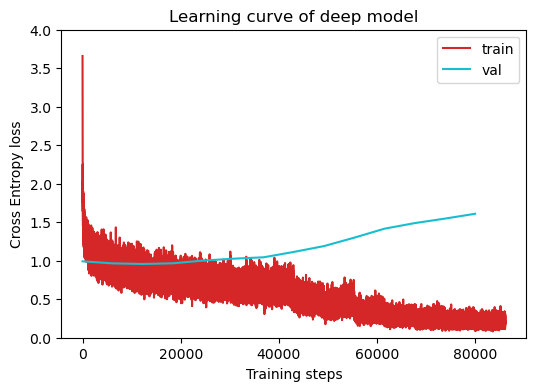

In [26]:
plot_learning_curve_loss(model_loss_record, title='deep model')

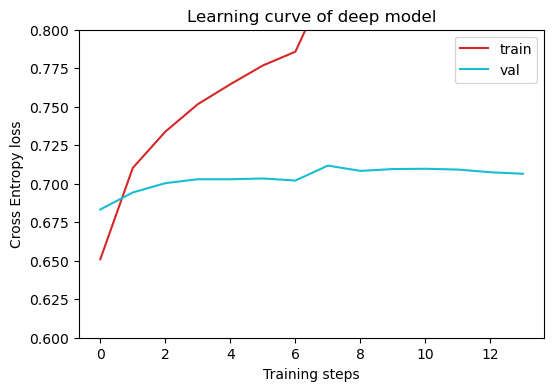

In [27]:
plot_learning_curve_acc(model_acc_record, title='deep model')